# 

In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from dataclasses import dataclass

import bayes3d as b3d

need_pytorch3d=False
try:
    import pytorch3d as pt3d
except ModuleNotFoundError:
    need_pytorch3d=True

In [2]:
need_pytorch3d

False

In [3]:
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [4]:
torch.cuda.is_available()

True

In [5]:
import pytorch3d as pt3d
from pytorch3d.io import IO, load_objs_as_meshes
from pytorch3d.structures import Meshes
import pytorch3d.transforms as transforms
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftSilhouetteShader,
)

In [6]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

pt3dio = IO()

In [7]:
b3d.utils.get_assets_dir()

'/home/matin/bayes3d/assets'

In [8]:
def scale_and_center(mesh, scale=None):
    verts = mesh.verts_packed()
    center = verts.mean(0)
    if scale is None:
        scale = max((verts - center).abs().max(0)[0])
    mesh.offset_verts_(-center)
    mesh.scale_verts_((1.0 / float(scale)))

In [9]:
def extent(mesh):
    verts = mesh.verts_packed()
    return verts.max(0).values -  verts.min(0).values

In [10]:
model_dir = b3d.utils.get_assets_dir() + '/bop/ycbv/models'
mug_mesh = pt3dio.load_mesh(model_dir + '/obj_000014.ply', include_textures=False, device=device)
cube_mesh = load_objs_as_meshes([b3d.utils.get_assets_dir() + '/sample_objs/cube.obj'], load_textures=False, device=device)

scale_and_center(mug_mesh, scale=1e2)
scale_and_center(cube_mesh, scale=10000)

In [11]:
extent(mug_mesh), extent(cube_mesh)

(tensor([1.1697, 0.9307, 0.8138], device='cuda:0'),
 tensor([1.0000e-04, 1.0000e-04, 1.0000e-04], device='cuda:0'))

In [12]:
type(extent(mug_mesh))

torch.Tensor

In [13]:
@dataclass
class SE3:
    rot: torch.Tensor
    tra: torch.Tensor

    def __mul__(self, other):
        new_rot = torch.matmul(self.rot, other.rot)
        new_tra = self.tra + torch.matmul(self.rot, other.tra)
        return SE3(new_rot, new_tra)

    def inv(self):
        rinv = torch.inverse(self.rot)
        return SE3(rinv, -torch.matmul(rinv, self.tra))

    def conj(self, other):
        return other.inv() * self * other

In [14]:
DIST = 2.7
ELEV = 0.0 # 30
AZIM = 0.0 
def get_scene_transforms(obj_transforms):
    R_0, T_0 = look_at_view_transform(dist=DIST, elev=ELEV, azim=AZIM)
    cam_tr = SE3(R_0[0, ...].to(dtype=torch.float64), T_0[0, ...].to(dtype=torch.float64))
    obj_tr = SE3(torch.from_numpy(np.eye(3)), torch.from_numpy(np.zeros(3)))
    for new_tr in obj_transforms:
        #obj_tr, cam_tr = new_tr * obj_tr, cam_tr * new_tr.conj(obj_tr)
        obj_tr, cam_tr = obj_tr * new_tr, cam_tr * new_tr
    return cam_tr.rot[None, ...], cam_tr.tra[None, ...]

In [15]:
_obj_transforms = [ # left-handed around y
    SE3(torch.from_numpy(np.eye(3)), torch.from_numpy(np.array([-0.2, 0.0, 0.3]))),
    SE3(transforms.axis_angle_to_matrix(torch.from_numpy(-torch.pi/2 * np.array([1.0, 0.0, 0.0]))),
        torch.from_numpy(np.array([0.0, 0.0, 0.0]))),
    SE3(transforms.axis_angle_to_matrix(torch.from_numpy(torch.pi/3 * np.array([0.0, 0.0, 1.0]))),
        torch.from_numpy(np.array([0.0, 0.0, 0.0]))),
    #SE3(transforms.axis_angle_to_matrix(torch.from_numpy(-torch.pi/2 * np.array([1.0, 0.0, 0.0]))),
        #torch.from_numpy(np.array([0.0, 0.0, 0.0]))),
    #SE3(torch.from_numpy(np.eye(3)), torch.from_numpy(np.array([0.0, 0.5, 0.0]))),
]

In [16]:
IMG_SIZE = 100
def render_images(dists, elevs, azims): #dx, dy, theta):
    batch_size = 1 if dists.shape == torch.Size([]) else dists.shape[0]
    R, T = look_at_view_transform(dist=dists, elev=elevs, azim=azims, degrees=False)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    raster_settings = RasterizationSettings(image_size=IMG_SIZE, blur_radius=0.0, faces_per_pixel=1, bin_size=0)
    rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
    return rasterizer(mug_mesh.extend(batch_size)).zbuf

In [17]:
render_images(torch.tensor([2.7, 2.7]), 
              torch.tensor([torch.pi/2, 0.0]), 
              torch.tensor([0.0, 0.0])).shape

torch.Size([2, 100, 100, 1])

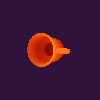

In [18]:
b3d.viz.get_depth_image(render_images(torch.tensor([2.7]),
                                      torch.tensor([0]),
                                      torch.tensor([1.0 * torch.pi/6])).reshape(IMG_SIZE, IMG_SIZE).cpu().numpy())

In [19]:
DIST_MEAN = 2.7
DIST_STD  = 2.0
ELEV_MEAN = torch.pi
ELEV_STD  = torch.pi/2
AZIM_MEAN = torch.pi
AZIM_STD  = torch.pi/2
def generate_images(n):
    z1, z2, z3 = torch.randn(3, n, device=device)
    dists = DIST_MEAN + DIST_STD * z1
    elevs = ELEV_MEAN + ELEV_STD * z2
    azims = AZIM_MEAN + AZIM_STD * z3
    return render_images(dists, elevs, azims)

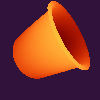

In [20]:
b3d.viz.get_depth_image(generate_images(1).reshape(IMG_SIZE, IMG_SIZE).cpu().numpy())

# VAE Inference

In [21]:
import torch.nn as nn
from torch.optim import Adam

In [22]:
class Decoder(nn.Module):
    def __init__(self, std: float):
        super(Decoder, self).__init__()
        self.std = std
        self.pixelwise_dist = torch.distributions.normal.Normal(loc=0, scale=std)
        
    def forward(self, dists, elevs, azims):
        n_batches = dists.shape[0]
        noiseless_img = render_images(dists, elevs, azims)
        #noise = std * torch.randn_like(noiseless_img, device=device)
        return noiseless_img.reshape(n_batches, 1, IMG_SIZE, IMG_SIZE)
        
    def log_likelihood(self, gt_imgs, recon_imgs):
        noises = recon_imgs - gt_imgs
        return self.pixelwise_dist.log_prob(noises).sum(axis=(1, 2, 3))

In [23]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=10, stride=3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2)
        self.linear1 = nn.Linear(1152, 1024)
        self.linear2 = nn.Linear(1024, 1024)
        self.linear3 = nn.Linear(1024, 576)
        self.linear4 = nn.Linear(576, 192)
        self.linear5 = nn.Linear(192, 24)
        self.linear6 = nn.Linear(24, 6)

        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, imgs):
        x = self.conv1(imgs)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        
        x = self.linear1(x.reshape(imgs.shape[0], -1))
        x = self.relu(x)
        
        x = self.linear2(x)
        x = self.relu(x)
        
        x = self.linear3(x)
        x = self.relu(x)

        x = self.linear4(x)
        x = self.relu(x)

        x = self.linear5(x)
        x = self.relu(x)

        x = self.linear6(x)
        means, vars = x[:3], self.softplus(x[3:])
        return torch.cat((means, vars))

In [24]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def sample_scene_params(self, latentss):
        batch_size = latentss.shape[0]
        meanss, stdevss = latentss[:, :3], latentss[:, 3:]
        z1, z2, z3 = torch.randn(3, batch_size, device=device)
        dists = meanss[:, 0] + stdevss[:, 0]*z1
        elevs = meanss[:, 1] + stdevss[:, 1]*z2
        azims = meanss[:, 2] + stdevss[:, 2]*z3
        return dists, elevs, azims
 
    def forward(self, imgs):
        latentss = self.encoder(imgs)
        dists, elevs, azims = self.sample_scene_params(latentss)
        reconstructions = self.decoder(dists, elevs, azims)
        return reconstructions, latentss

In [25]:
def gaussian_kl(mean1, std1, mean2, std2): # KL(N(mean1, std1**2) || N(mean2, std2**2))
    var1, var2 = std1**2, std2**2
    return 1/2 * (var1/var2 - 1 + torch.log(var2) - torch.log(var1) + (mean1 - mean2)**2/var2)

In [26]:
def loss_fn(vae, gt_imgs, recon_imgs, latentss):
    recon_loss = -vae.decoder.log_likelihood(gt_imgs, recon_imgs)
    means, stdevs = latentss[:, :3], latentss[:, 3:]
    prior_loss = gaussian_kl(means, stdevs, 
                             torch.tensor([DIST_MEAN, ELEV_MEAN, AZIM_MEAN], device=device),
                             torch.tensor([DIST_STD, ELEV_STD, AZIM_STD], device=device)).sum()
    return (recon_loss + prior_loss).sum()

In [36]:
N = 30000

In [37]:
silly_dataset = generate_images(N)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.77 GiB total capacity; 12.66 GiB already allocated; 2.12 MiB free; 13.84 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
silly_dataset = silly_dataset.reshape([N, 1, 100, 100])

In [ ]:
vae = VAE(Encoder(), Decoder(std=0.05)).to(device)

In [ ]:
optimizer = Adam(vae.parameters(), lr=1e-9)

In [38]:
BATCH_SIZE = 1000
assert N % BATCH_SIZE == 0
n_batches = N // BATCH_SIZE

In [34]:
losses = []
vae.train()

for epoch in range(10):
    overall_loss = 0

    batch_perm = np.random.permutation(1000)
    
    for batch_idx in range(1, 6):
        batch_slice = batch_perm[(batch_idx-1)*200:batch_idx*200]
        batch = silly_dataset[batch_slice, :, :, :]

        optimizer.zero_grad()
    
        reconstructions, latentss = vae(batch)
        loss = loss_fn(vae, batch, reconstructions, latentss)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    losses.append(overall_loss / 1000)
    
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", losses[-1])

	Epoch 1 complete! 	Average Loss:  3786908.608
	Epoch 2 complete! 	Average Loss:  3634465.664
	Epoch 3 complete! 	Average Loss:  3668520.384
	Epoch 4 complete! 	Average Loss:  3700517.824
	Epoch 5 complete! 	Average Loss:  3752207.616
	Epoch 6 complete! 	Average Loss:  3732335.68
	Epoch 7 complete! 	Average Loss:  3651687.872
	Epoch 8 complete! 	Average Loss:  3699321.984
	Epoch 9 complete! 	Average Loss:  3710137.792
	Epoch 10 complete! 	Average Loss:  3684436.224


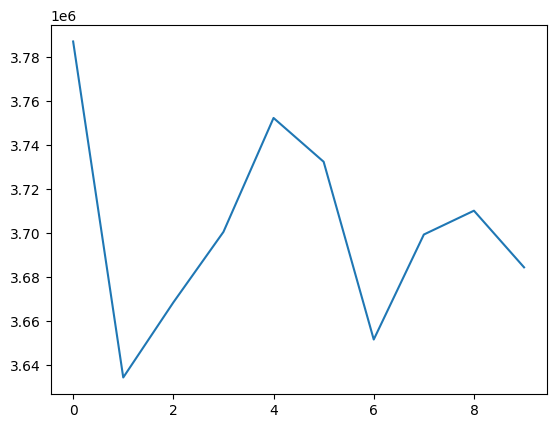

In [35]:
plt.plot(losses)